# **Cell Instance Segmentation**

github repo:
https://github.com/mingxuanche99/cell-instance-segmentation

# Introduction
Current solutions for instance segmentation of cells have limited accuracy for neuronal cells in particular. This could be because neuronal cells have a very unique, irregular and concave morphology, making them challenging to segment with commonly used mask heads. 
In this project, we are applying segmentation on medical images with resolution of 704x520 of neuronal cells.We got 600 labeled neuronal cell images, using run length encoded masks as training annotations. The method we used including k-means, CNN, U-net and U-net with attention. This notebook shows ourwork

# **1.Importing the required libraries**

In this part, we import the required python libraries for this project, including pytorch,cv2, sklearn, pandas,numpy,matplotlib and so on.

In [1]:
import numpy as np 
import pandas as pd
import os
import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# import torchvision.transforms.functional as TF

import random
import os, shutil
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from os.path import join
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import cv2

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, sampler
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score,recall_score,precision_score


# **2.Data Loading and Preprocessing**

This part mainly completes the data loading, decoding the mask data and data augmentation. The dataset in our project including 2 parts, a csv file and a folder containing 606 images. In the csv file, each row contain a image id and annotation, the annotation can be decode as a mask, which reveals a true cell instance.

Data Source: https://www.kaggle.com/mingxuanche/sartorius-cell-instance-segmentation-pyt-19d48f/data

### Loading Data

In [2]:
data_train = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')

In [3]:
data_train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [4]:
DATA_PATH = '../input/sartorius-cell-instance-segmentation'
TRAIN_CSV = join(DATA_PATH,'train.csv')
TRAIN_PATH = join(DATA_PATH,'train')
df_train = pd.read_csv(TRAIN_CSV)
print(f'Training Set Shape: {df_train.shape} - {df_train["id"].nunique()} \
Images - Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape: (73585, 9) - 606 Images - Memory Usage: 5.05 MB


### Decoding data and build masks for all images

In [5]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)
def build_masks(df_train, image_id, input_shape):
    height, width = input_shape
    labels = df_train[df_train["id"] == image_id]["annotation"].tolist()
    mask = np.zeros((height, width))
    for label in labels:
        mask += rle_decode(label, shape=(height, width))
    mask = mask.clip(0, 1)
    return np.array(mask)


### Data processing and augmentation

In [6]:
class CellDataset(Dataset):
    def __init__(self, df: pd.core.frame.DataFrame, train:bool):
        self.IMAGE_RESIZE = (224, 224)
        self.RESNET_MEAN = (0.485, 0.456, 0.406)
        self.RESNET_STD = (0.229, 0.224, 0.225)
        self.df = df
        self.base_path = TRAIN_PATH
        self.gb = self.df.groupby('id')
        self.transforms = Compose([Resize(self.IMAGE_RESIZE[0],  self.IMAGE_RESIZE[1]),
                                   Normalize(mean=self.RESNET_MEAN, std= self.RESNET_STD, p=1),
                                   HorizontalFlip(p=0.5),
                                   VerticalFlip(p=0.5)])
        
        # Split train and val set
        all_image_ids = np.array(df_train.id.unique())
        np.random.seed(42)
#         iperm = np.random.permutation(len(all_image_ids))
        num_train_samples = int(len(all_image_ids) * 0.9)

        if train:
            self.image_ids = all_image_ids[:num_train_samples]
        else:
             self.image_ids = all_image_ids[num_train_samples:]

    def __getitem__(self, idx: int) -> dict:

        image_id = self.image_ids[idx]
        df = self.gb.get_group(image_id)

        # Read image
        image_path = os.path.join(self.base_path, image_id + ".png")
        image = cv2.imread(image_path)

        # Create the mask
        mask = build_masks(df_train, image_id, input_shape=(520, 704))
        mask = (mask >= 1).astype('float32')
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        # print(np.moveaxis(image,0,2).shape)
        return np.moveaxis(np.array(image),2,0), mask.reshape((1, self.IMAGE_RESIZE[0], self.IMAGE_RESIZE[1]))


    def __len__(self):
        return len(self.image_ids)

In [7]:
ds_train = CellDataset(df_train, train=True)
dl_train = DataLoader(ds_train, batch_size=16, num_workers=2, pin_memory=True, shuffle=False)

In [8]:
ds_test = CellDataset(df_train, train=False)
dl_test = DataLoader(ds_test, batch_size=4, num_workers=2, pin_memory=True, shuffle=False)


# **3.Data explore and Visualization**

In [9]:
df_train=data_train
df_train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


### Image Information
From the `train.csv`, all the images have the same shape *704 x 520* which contains no variable image resolution problem. However, there is only 606 images in the tarin set. The number of rows in this file is far more than 606 which indicates there are more than 1 instances in 1 image.

In [11]:
print(f'Number of images: {df_train.id.nunique()}')

Number of images: 606


The number of instances in each image is different which varys from 4 to 790.

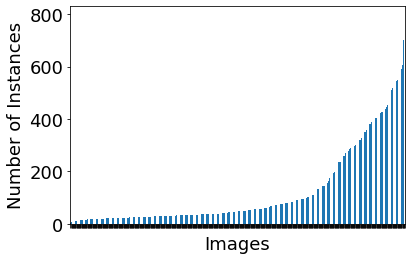

In [12]:
fig, ax = plt.subplots()

ninstances_per_image = df_train[['id']].value_counts().sort_values()
ninstances_per_image.index = range(606)
ninstances_per_image.median()
ninstances_per_image.plot.bar(ax=ax)

ax.set_xticklabels([])
ax.set_xlabel('Images')
ax.set_ylabel('Number of Instances')
plt.show()

Observing this data, it is easy to find each image is associated with a unique cell type. Those types are cort (neurons), shsy5y (neuroblastoma) and astro (astrocytes).

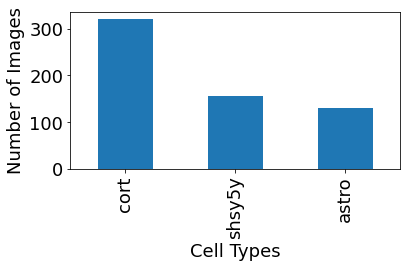

In [13]:
fig, ax = plt.subplots(1, 1)
df_train.groupby(['id','cell_type'])['cell_type'].first().value_counts().plot.bar(ax=ax)
ax.set_ylabel('Number of Images')
ax.set_xlabel('Cell Types')
fig.tight_layout()
plt.show()

### 3.2 Image
Here we first show 3 image of each cell types, then randomly show 9 image, then show the relationship of image and mask.

In [14]:
def decode_rle_mask(rle_mask, shape):

    rle_mask = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle_mask[0:][::2], rle_mask[1:][::2])]
    starts -= 1
    ends = starts + lengths

    mask = np.zeros((shape[0] * shape[1]), dtype=np.uint8)
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    mask = mask.reshape(shape[0], shape[1])
    return mask

def visualize_image(df, image_id):   
    image_path = df.loc[df['id'] == image_id, 'id'].values[0]
    cell_type = df.loc[df['id'] == image_id, 'cell_type'].values[0]
    plate_time = df.loc[df['id'] == image_id, 'plate_time'].values[0]
    sample_date = df.loc[df['id'] == image_id, 'sample_date'].values[0]
    sample_id = df.loc[df['id'] == image_id, 'sample_id'].values[0]

    image = cv2.imread(f'../input/sartorius-cell-instance-segmentation/train/{image_path}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    fig, axes = plt.subplots(figsize=(10, 10), ncols=2)
    fig.tight_layout(pad=5.0)
    
    axes[0].imshow(image, cmap='gray')
    masks = []
    for mask in df.loc[df['id'] == image_id, 'annotation'].values:
        decoded_mask = decode_rle_mask(rle_mask=mask, shape=image.shape)
        masks.append(decoded_mask)
    mask = np.stack(masks)
    mask = np.any(mask == 1, axis=0)
    axes[1].imshow(image, cmap='gray')
    axes[1].imshow(mask, alpha=0.4)

    for i in range(2):
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', labelsize=10, pad=10)
        axes[i].tick_params(axis='y', labelsize=10, pad=10)
        
    axes[0].set_title(f'{image_path} - {cell_type} Annotations\n{plate_time} - {sample_date} - {sample_id}', fontsize=10, pad=12)
    axes[1].set_title('Segmentation Mask', fontsize=10, pad=12)
    plt.show()
    plt.close(fig)

#### astro cells

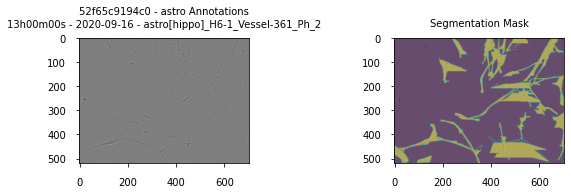

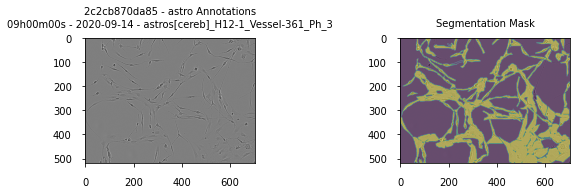

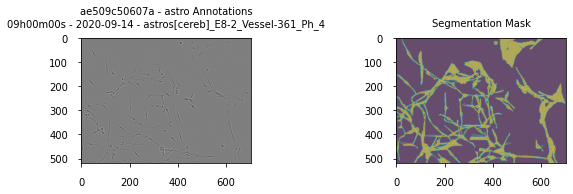

In [15]:
select_image_ids = []
select_image_ids.append(df_train.loc[df_train['cell_type'] == 'astro', 'id'].sample(1).to_list()[0])
select_image_ids.append(df_train.loc[df_train['cell_type'] == 'astro', 'id'].sample(2).to_list()[0])
select_image_ids.append(df_train.loc[df_train['cell_type'] == 'astro', 'id'].sample(3).to_list()[0])

for image_id in select_image_ids:
     visualize_image(df=df_train, image_id=image_id)

#### cort cells

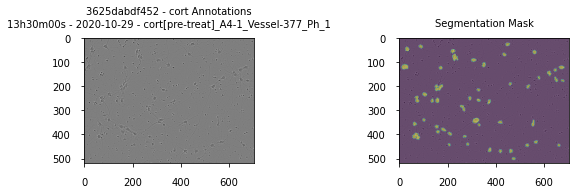

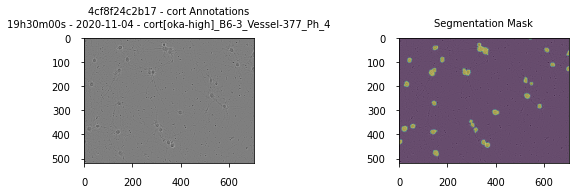

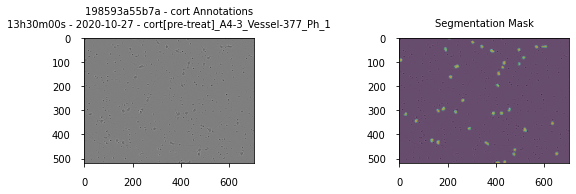

In [16]:
select_image_ids = []
select_image_ids.append(df_train.loc[df_train['cell_type'] == 'cort', 'id'].sample(1).to_list()[0])
select_image_ids.append(df_train.loc[df_train['cell_type'] == 'cort', 'id'].sample(2).to_list()[0])
select_image_ids.append(df_train.loc[df_train['cell_type'] == 'cort', 'id'].sample(3).to_list()[0])

for image_id in select_image_ids:
     visualize_image(df=df_train, image_id=image_id)

#### shsy5y cell

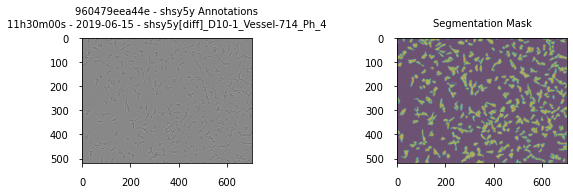

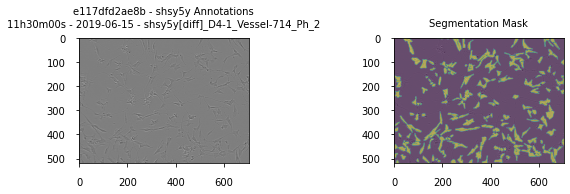

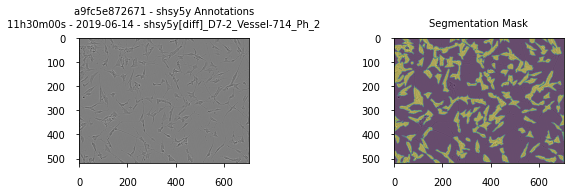

In [17]:
select_image_ids = []
select_image_ids.append(df_train.loc[df_train['cell_type'] == 'shsy5y', 'id'].sample(1).to_list()[0])
select_image_ids.append(df_train.loc[df_train['cell_type'] == 'shsy5y', 'id'].sample(2).to_list()[0])
select_image_ids.append(df_train.loc[df_train['cell_type'] == 'shsy5y', 'id'].sample(3).to_list()[0])

for image_id in select_image_ids:
     visualize_image(df=df_train, image_id=image_id)

### Random image

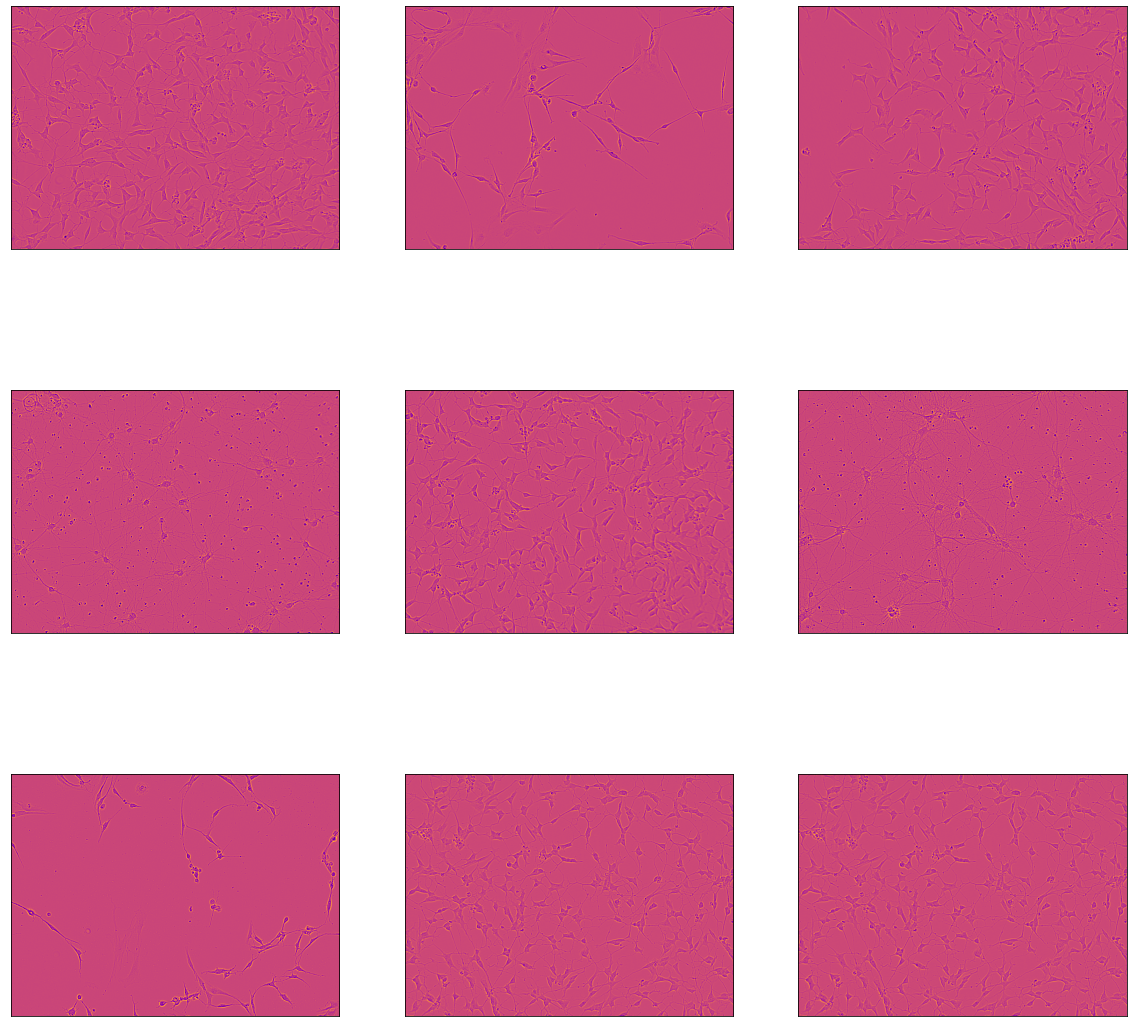

In [18]:
def imshow(num_to_show=9):
    
    plt.figure(figsize=(20,20))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        img = mpimg.imread(f'../input/sartorius-cell-instance-segmentation/train/{data_train.iloc[i*500,0]}.png')
        plt.imshow(img, cmap='plasma')

imshow()

### Relationship between image and mask

image shape: torch.Size([16, 3, 224, 224]),
mask shape:torch.Size([16, 1, 224, 224]),
batch len: 2


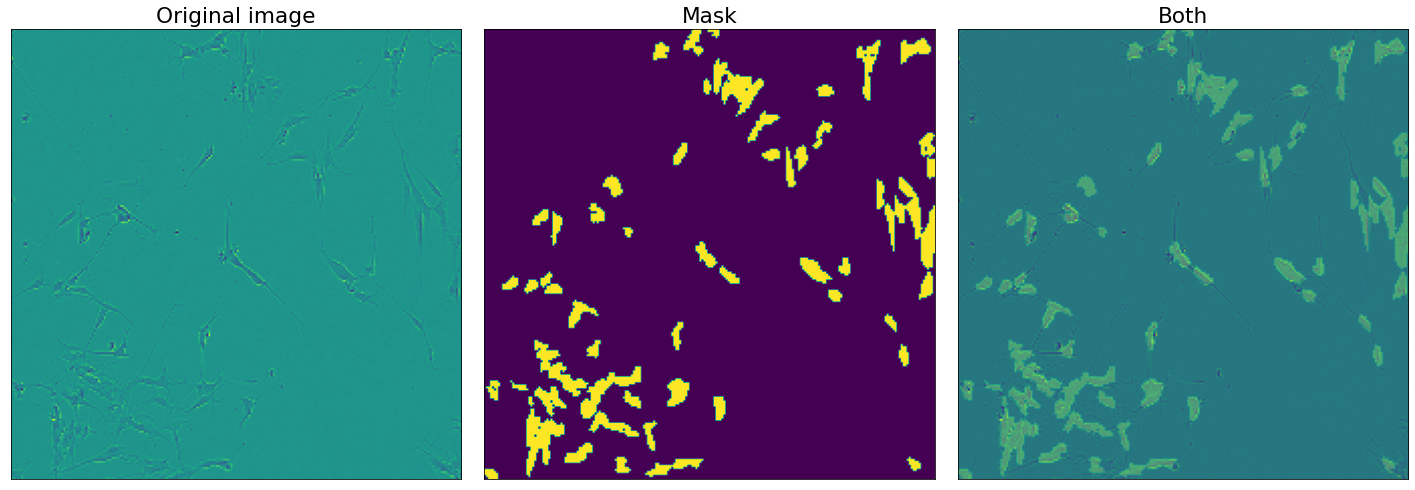

In [19]:
# plot simages and mask from dataloader
batch = next(iter(dl_train))
images, masks = batch
print(f"image shape: {images.shape},\nmask shape:{masks.shape},\nbatch len: {len(batch)}")
k=11
plt.figure(figsize=(20, 20))
        
plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(images[k][0])
plt.title('Original image')

plt.subplot( 1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(masks[k][0])
plt.title('Mask')

plt.subplot( 1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(images[k][0])
plt.imshow(masks[k][0],alpha=0.2)
plt.title('Both')
plt.tight_layout()
plt.show()

# 4.K-means

In this part, we use k-means to achieve cell instance segmentation task.

### Helper class to load data, transfer mask to RLE, and binarization images.

In [20]:
class RLE:
    def __init__(self):
        return
    def mask2rle(self, img):
        '''
        Efficient implementation of mask2rle, from @paulorzp
        --
        img: numpy array, 1 - mask, 0 - background
        Returns run length as string formated
        Source: https://www.kaggle.com/xhlulu/efficient-mask2rle
        '''
        pixels = img.T.flatten()
        pixels = np.pad(pixels, ((1, 1),))
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)


    def rle_decode(self, mask_rle, shape, color=1):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height, width, channels) of array to return
        color: color for the mask
        Returns numpy array (mask)

        '''
        s = mask_rle.split()
        starts = list(map(lambda x: int(x) - 1, s[0::2]))
        lengths = list(map(int, s[1::2]))
        ends = [x + y for x, y in zip(starts, lengths)]

        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

        for start, end in zip(starts, ends):
            img[start: end] = color

        return img.reshape(shape)
    
    def loadData(self):
#         df = pd.read_csv(f'../input/sartorius-cell-instance-segmentation/train.csv')
        df = df_train
        df['image_path'] = TRAIN_PATH + '/' + df['id'] + '.png'
        # data = df.head(2)
        # labels = ['id', 'annotation', 'width', 'height', 'cell_type',
        #           'plate_time', 'sample_date', 'sample_id', 'elapsed_timedelta']
        # annotation = df['annotation']
        tmp_df = df.drop_duplicates(subset=["id", "image_path"]).reset_index(drop=True)
        tmp_df["annotation"] = df.groupby("id")["annotation"].agg(list).reset_index(drop=True)
        df = tmp_df.copy()
#         print(df['image_path'][20])
        return df
    
    def show(self, winname, src):
        cv2.namedWindow(winname, cv2.WINDOW_GUI_NORMAL)
        cv2.imshow(winname, src)
    #     cv2.waitKey()
    
    def thre_method(self, img_src):
        ret, thresh = cv2.threshold(img_src, 127, 255, cv2.THRESH_BINARY)
        thresh_gray = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
        return thresh_gray

### Implement K-means clustering, and caculate accuracy and F1 score of results.

../input/sartorius-cell-instance-segmentation/train/0140b3c8f445.png


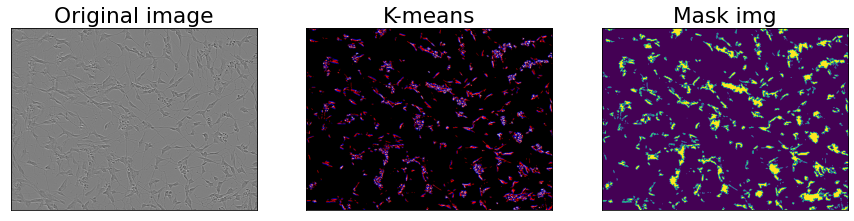

acc: 0.7642892263986014
f1: 0.312551372413889


In [21]:
rle = RLE()
    
def Kmeans(data, imageIndex):
    print(data['image_path'][1])
    fileName = data['image_path'][imageIndex]
    img = cv2.imread(fileName)

    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.title('Original image')
    
    img = cv2.fastNlMeansDenoising(img, 10, 10, 7, 21)


    data = img.reshape((-1, 3))
    data = np.float32(data)
    
    # set parameters of K-means
    critera = (cv2.TermCriteria_EPS+cv2.TermCriteria_MAX_ITER, 10, 0.1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    
    # Implement K-means
    r, best, center = cv2.kmeans(data, 4, None, criteria=critera, attempts=10, flags=flags)

    center = np.uint8(center)

    # set different color to the image
    data[best.ravel() == 0] = (0, 0, 0)
    data[best.ravel() == 1] = (0, 0, 255)
    data[best.ravel() == 2] = (255, 0, 0)
    data[best.ravel() == 3] = (255, 255, 255)

    data = np.uint8(data)
    oi = data.reshape((img.shape))

    # show image
    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(oi)
    plt.title('K-means')

    thre = rle.thre_method(oi)

    contours, _ = cv2.findContours(thre, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # make a mask
    img_mask = np.zeros(thre.shape, np.uint8)
    
    cv2.drawContours(img_mask, contours, -1, (255, 255, 255), -1)

    # kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
    # img_mask = cv.morphologyEx(img_mask, cv.MORPH_OPEN, kernel)

    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_mask)
    plt.title('Mask img')
    plt.show()
    flat_image = img_mask.flatten()
    r = list(rle.mask2rle(img_mask))

    return r, flat_image


def accuracy(index):
    data = rle.loadData()
    _, labels = testKmeans(index)
    _, predicted = Kmeans(data, index)
    acc = accuracy_score(labels, predicted)
    print('acc:', acc)
    black_img = np.zeros([520, 704], dtype=np.uint8)
    black_img = black_img.flatten()
    acc_blk = accuracy_score(labels, black_img)
#     print('blk acc:', acc_blk)
    f1_blk = f1_score(labels, black_img, average='macro')
    f1 = f1_score(labels, predicted, average='macro')
    print('f1:', f1)
#     print('f1_black:', f1_blk)
    

def testKmeans(imageIndex):

    shape = (520, 704, 3)
    data = rle.loadData()
    lens = 0
    for i in range(len(data['annotation'][imageIndex])):
        if i == 0:
            mask = rle.rle_decode(data['annotation'][imageIndex][i], shape)
            lens = len(data['annotation'][imageIndex][i])
        else:
            mask = cv2.add(mask, rle.rle_decode(data['annotation'][imageIndex][i], shape))
            lens += len(data['annotation'][imageIndex][i])
        fileName = data['image_path'][imageIndex]
        
    img = cv2.imread(fileName)
    mask *= 255.0
    mask = mask.astype(np.uint8)

    mask_img = cv2.addWeighted(img, 1, mask, 0.2, 0)

#     cv2.imshow('origin', img)
#     cv2.imshow('mask', mask)
#     cv2.imshow('mask img', mask_img)
    plt.figure(figsize=(15,15))
    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.title('Original image')
    
    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mask)
    plt.title('Annotation Mask')
    
    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mask_img)
    plt.title('Mask image')

    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    flat_mask = mask.flatten()

    return mask, flat_mask


rle = RLE()
imageIndex = 15
# mask, flat_mask = testKmeans(imageIndex)
accuracy(imageIndex)

### Evaluation of K-means clustering

### 1.Noising

For instance, when cells are hiding in lots of noise dots, it's tough for K-means to tell apart cells from noise dots. We try to eliminate image noise by performing morphological processing, such as combining expansion and corrosion, namely, open and closed operations, and to obtain the main object in the image, it turns out that in the images with less noise, the contours of some cells are lost in the open and closed operations, while for the images with the noise close to the cell contour shape, a large area of the cell contour is fused into a whole piece.

### 2.Mis-classification
For the parameter K = 4, the contour, background and some internal structures are classified respectively, however, some images can't be classified correctly, since they have less internal structure than usual images. 

### 3.Generalization
Besides, the generalization of K-means is not good, for we don't actually know the logic of annotation which is labeled by professionals. K-means can only get the contour of most of cells, without considering the inner logic of segmentation.

# **5.CNN**

Here, we use CNN to achieve cell instance segmentation task. In this task, the input of CNN is the original image, and the output should be the mask image. In this part, four layers of fully convolutional network was used to extract feature and output mask.

### Implement of CNN model

In [22]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.cov1=nn.Conv2d(in_channels, 20, kernel_size=5, padding="same")
        self.btn=nn.BatchNorm2d(20)
        self.relu=nn.ReLU()
        self.cov2=nn.Conv2d(20, 10, kernel_size=1)
        self.cov3=nn.Conv2d(10, 10, kernel_size=5, padding="same")
        self.btn2=nn.BatchNorm2d(10)
        self.cov4=nn.Conv2d(10, num_classes, kernel_size=1)
        self.sigmod=nn.Sigmoid()
        
    def forward(self, x):
        # print(x.shape)
        x1 = self.cov1(x)
        # print(x1.shape)
        x2 = self.btn(x1)
        # print(x2.shape)
        x3 = self.relu(x2)
        # print(x3.shape)
        x4 = self.cov2(x3)
        # print(x4.shape)
        x5 = self.cov3(x4)
        # print(x5.shape)
        # print('up')
        x = self.btn2(x4)
        # print(x.shape)
        x = self.relu(x)
        # print(x.shape)
        x = self.cov4(x)
        # print(x.shape)
        x = self.sigmod(x)
        # print(x.shape)
        return x

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device=torch.device('cpu')

### Implement of training loop and evaluate loop 

In [24]:
!pip install livelossplot==0.3.4
from livelossplot import PlotLosses

liveloss = PlotLosses()
def train_loop(model, optimizer, criterion, train_loader, device=device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)
        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item()*imgs.shape[0]  # += loss * current batch size
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader.sampler)
    return running_loss

In [25]:
def eval_loop(model, criterion, eval_loader, device=device):
    running_loss = 0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [],[]
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        
        for imgs, masks in pbar:
            # pass to device
            li=imgs
            lm=masks
            imgs = imgs.to(device)
            masks = masks.to(device)
            # forward
            out = model(imgs)
#             print(out.shape)
            loss = criterion(out, masks)
            running_loss += loss.item()*imgs.shape[0]
            
            # calculate predictions using output
            predicted = (out > 0.5).float()
            predicted = predicted.view(-1).cpu().numpy()
            labels = masks.view(-1).cpu().numpy()
            accuracy.append(accuracy_score(labels, predicted))
            f1_scores.append(f1_score(labels, predicted))
            
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    running_loss /= len(eval_loader.sampler)
    return {
        'accuracy':acc,
        'f1_macro':f1, 
        'loss':running_loss,
        'img': li,
        'masks': lm,
        'out':out
    }

In [26]:
def train(model, optimizer, criterion, train_loader, valid_loader,
          device=device, 
          num_epochs=25, 
          valid_loss_min=np.inf,
          logdir='logdir'):
    
    tb_writer = SummaryWriter(log_dir=logdir)
    val_loss_list = []
    for e in range(num_epochs):
        # train for epoch
        train_loss = train_loop(
            model, optimizer, criterion, train_loader, device=device)
        # evaluate on validation set
        metrics = eval_loop(
            model, criterion, valid_loader, device=device
        )
        # show progress
        print_string = f'Epoch: {e+1} '
        print_string+= f'TrainLoss: {train_loss:.5f} '
        print_string+= f'ValidLoss: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f}'
        liveloss.update({'Training loss': metrics["loss"],'Accuracy': metrics["accuracy"]})
        liveloss.draw()
        # Tensorboards Logging
        tb_writer.add_scalar('UNet/Train Loss', train_loss, e)
        tb_writer.add_scalar('UNet/Valid Loss', metrics["loss"], e)
        tb_writer.add_scalar('UNet/Accuracy', metrics["accuracy"], e)
        tb_writer.add_scalar('UNet/F1 Macro', metrics["f1_macro"], e)

        # save the model 
        if metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = metrics["loss"]

### Train and evaluted

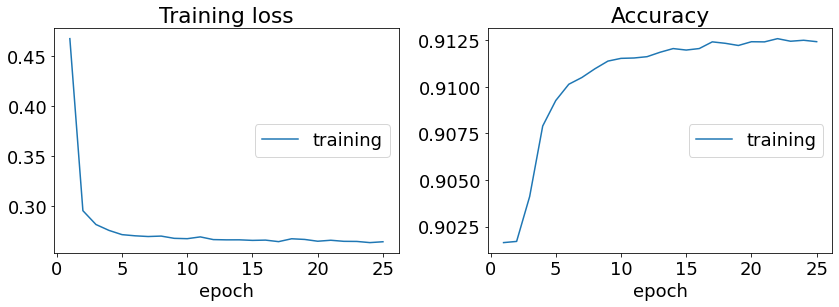

Training loss:
training   (min:    0.264, max:    0.467, cur:    0.265)

Accuracy:
training   (min:    0.902, max:    0.913, cur:    0.912)


In [27]:
model1 = CNN(3, 1).to(device)
optimizer = optim.Adam(model1.parameters(), lr=0.01)
criterion = nn.BCELoss()
train(model1, optimizer, criterion, dl_train, dl_test)

In [28]:
# Load the latest model
model1.load_state_dict(torch.load('model.pt'))
metrics = eval_loop(model1, criterion, dl_test)

print('accuracy:', metrics['accuracy'])
print('f1 macro:', metrics['f1_macro'])
print('test loss:', metrics['loss'])

Iterating over evaluation data:   0%|          | 0/16 [00:00<?, ?it/s]

accuracy: 0.912521050900829
f1 macro: 0.3223041260790899
test loss: 0.26361486706577364


# 6.Unet

Here, we use Unet to achieve cell instance segmentation task. The input and output are same as CNN. U-net is based on the expansion and modification of a fully convolutional network. The network consists of two parts: a contracting path to obtain contextual information and a symmetric expanding path to accurately locate.

### Implement of Unet

In [29]:
class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [30]:
class U_Net(nn.Module):
    """
    UNet - Basic Implementation
    Paper : https://arxiv.org/abs/1505.04597
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(U_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

        self.active = torch.nn.Sigmoid()

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)

        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)
        out = self.active(out)

        return out

### Training and evaluation

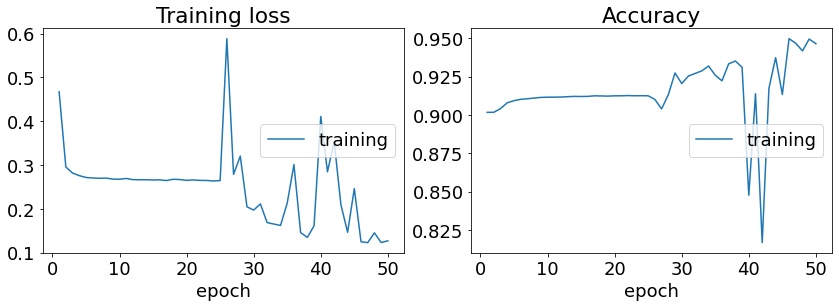

Training loss:
training   (min:    0.123, max:    0.588, cur:    0.127)

Accuracy:
training   (min:    0.817, max:    0.950, cur:    0.946)


In [31]:
# set_seed(21)
model2 = U_Net(3, 1).to(device)
optimizer = optim.Adam(model2.parameters(), lr=0.01)
criterion = nn.BCELoss()
train(model2, optimizer, criterion, dl_train, dl_test)

In order to make it easier to compare the methods, in this two picture, epoch 0-25 belongs to CNN,epoch 26-50 belong to Unet.

In [32]:
# Load the latest model
model2.load_state_dict(torch.load('model.pt'))
metrics = eval_loop(model2, criterion, dl_test)

print('accuracy:', metrics['accuracy'])
print('f1 macro:', metrics['f1_macro'])
print('test loss:', metrics['loss'])

Iterating over evaluation data:   0%|          | 0/16 [00:00<?, ?it/s]

accuracy: 0.9470202387595662
f1 macro: 0.6857867517414631
test loss: 0.12240597746167027


# 7.Attention Unet

Here, we use Unet to achieve cell instance segmentation task. The input and output are same as CNN. Attention Unet will use the attention gate (a kind of soft attention) to filter the current features after each layer of convolution when upsampling. Realize the attention mechanism by supervising the features of the last level through the features of the next level


### Implement of Attention Unet

In [33]:
class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out


class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=3, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)
#         print(out.shape)

        out = self.active(out)

        return out

### Training and evaluation

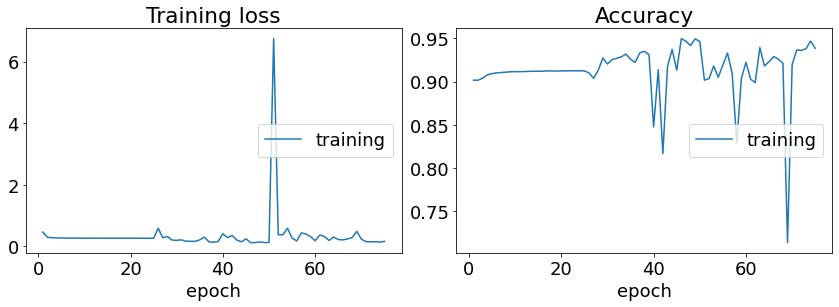

Training loss:
training   (min:    0.123, max:    6.746, cur:    0.166)

Accuracy:
training   (min:    0.714, max:    0.950, cur:    0.938)


In [34]:
# set_seed(21)
model3 = AttU_Net(3, 1).to(device)
optimizer = optim.Adam(model3.parameters(), lr=0.01)
criterion = nn.BCELoss()
train(model3, optimizer, criterion, dl_train, dl_test)

In order to make it easier to compare the methods, in this two picture, epoch 0-25 belongs to CNN,epoch 26-50 belong to Unet and epoch 51-75 belong to Attention Unet.

In [35]:
# Load the latest model
model3.load_state_dict(torch.load('model.pt'))
metrics = eval_loop(model3, criterion, dl_test)

print('accuracy:', metrics['accuracy'])
print('f1 macro:', metrics['f1_macro'])
print('test loss:', metrics['loss'])

Iterating over evaluation data:   0%|          | 0/16 [00:00<?, ?it/s]

accuracy: 0.9466705322265625
f1 macro: 0.6989304664962721
test loss: 0.13905572353816423


### Evaluation of Unet and Attention Unet
Combined with the accuracy rate, the Unet network is slightly better than the Attention Unet network in terms of effect. Possible reason:

Attention Unet uses a soft attention mechanism. Our data is a picture of nerve cells. The distribution is very random and cannot produce regional features. The attention mechanism is not well applied.


# **8. comparison of 3 supervised learning methods**

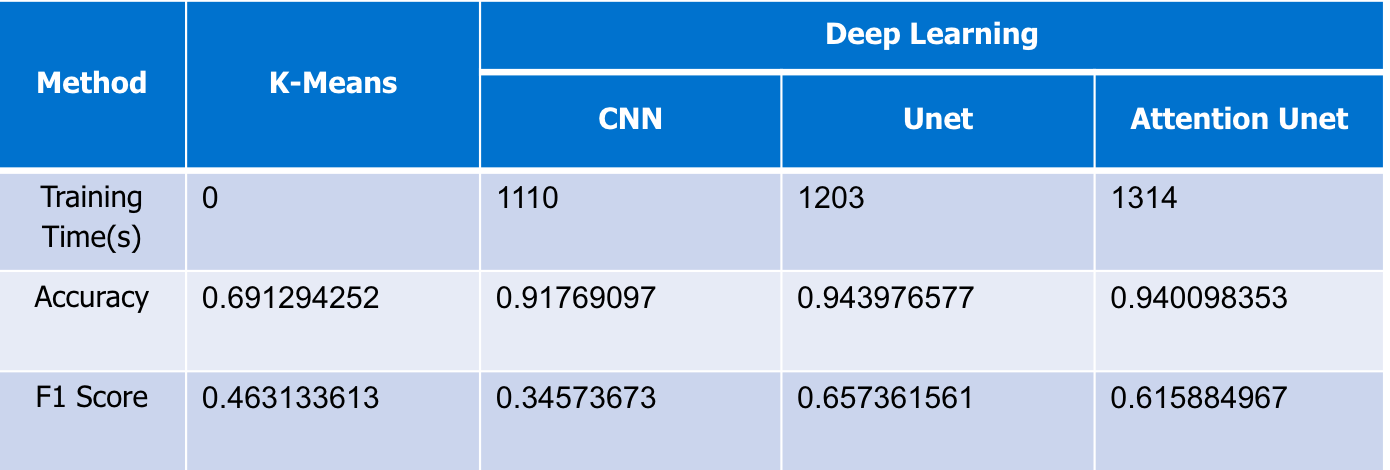

### Visualized results

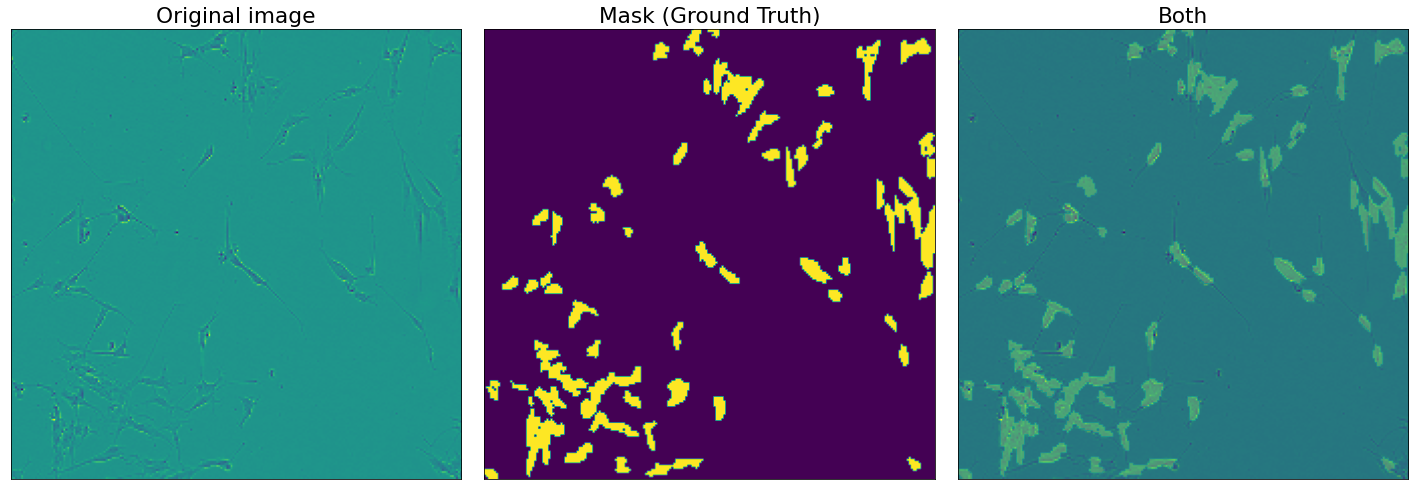

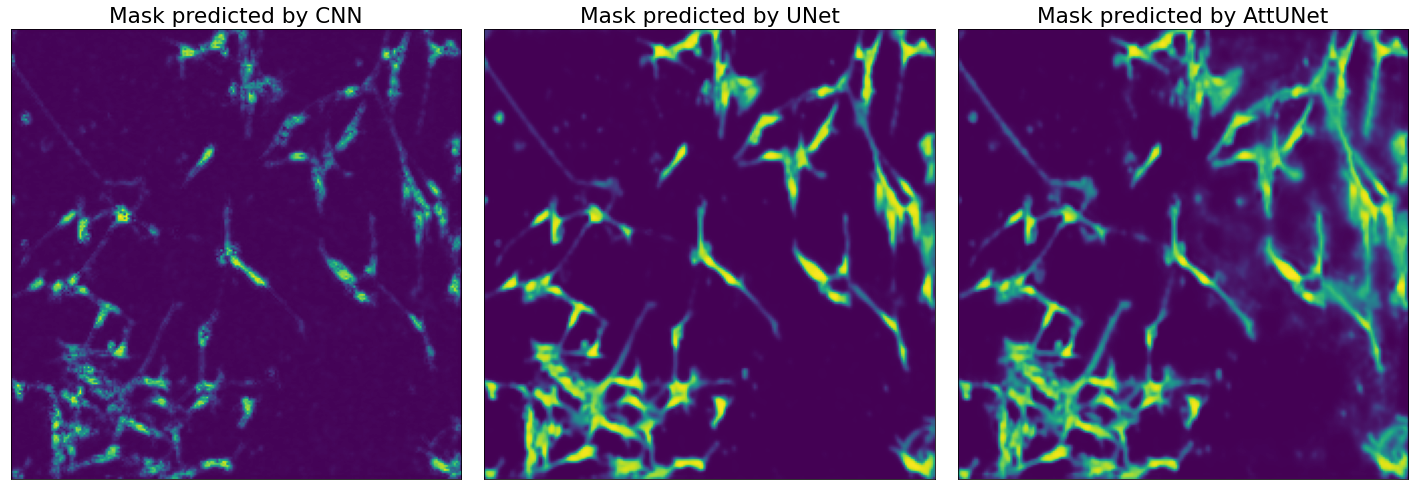

In [36]:
batchs = next(iter(dl_train))
images, masks = batchs
im=images
k=11
images = images.to(device)
plt.figure(figsize=(20, 20))
out1=model1(images)
out1=out1.cpu().detach()
out2=model2(images)
out2=out2.cpu().detach()
out3=model3(images)
out3=out3.cpu().detach()

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(im[k][1])
plt.title('Original image')

plt.subplot( 1, 3, 2)
plt.xticks([])
plt.yticks([])

plt.imshow(masks[k][0])
plt.title('Mask (Ground Truth)')

plt.subplot( 1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(im[k][1])
plt.imshow(masks[k][0],alpha=0.2)
plt.title('Both')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 20))
plt.subplot( 1, 3, 1)
plt.xticks([])
plt.yticks([])
# plt.imshow(im[k][1])
plt.imshow(out1[k][0])
plt.title('Mask predicted by CNN')

plt.subplot( 1, 3, 2)
plt.xticks([])
plt.yticks([])
# plt.imshow(im[k][1])
plt.imshow(out2[k][0])
plt.title('Mask predicted by UNet')

plt.subplot( 1, 3, 3)
plt.xticks([])
plt.yticks([])
# plt.imshow(im[k][1])
plt.imshow(out3[k][0])
plt.title('Mask predicted by AttUNet')

plt.tight_layout()
plt.show()

# 9. Conclusion

Combined with the accuracy rate and visualized results, we found that The results of Unet related method far exceed those of CNN and K-means, which may be due to the fact that this kind of U-shaped network is more suitable for cell image segmentation task. What's more,To our surprise, the Unet network is slightly better than the Attention Unet network in terms of effect. The possible reason might be Attention Unet uses a soft attention mechanism, but our data is a picture of nerve cells, so, the distribution is very random and cannot produce regional features. Therefore, the attention mechanism is not well applied.
